In [1]:
import numpy as np
import qutip
import qutip.control.pulseoptim as cpo
from qutip import fidelity
from qutip.control.optimresult import OptimResult

import interaction_constants
from qubit_system.geometry.regular_lattice_1d import RegularLattice1D
from qubit_system.qubit_system_classes import EvolvingQubitSystem
from qubit_system.utils.ghz_states import StandardGHZState
from qubit_system.utils.interpolation import get_hamiltonian_coeff_interpolation

In [2]:
N_RYD = 50
C6 = interaction_constants.get_C6(N_RYD)

LATTICE_SPACING = 1.5e-6

print(f"C6: {C6:.3e}")
characteristic_V = C6 / (LATTICE_SPACING ** 6)
print(f"Characteristic V: {characteristic_V:.3e} Hz")

t = 2e-6
n_ts = 300 # number of timesteps

C6: 1.555e-26
Characteristic V: 1.365e+09 Hz


In [3]:
def report_stats(result: OptimResult):
    result.stats.report()
    
    final_fidelity = fidelity(target_state, result.evo_full_final) ** 2
    print(f"final_fidelity: {final_fidelity:.5f}")
    
    print(f"Final gradient normal {result.grad_norm_final:.3e}")
    print(f"Terminated due to {result.termination_reason}")
    

# Unnormalised Hamiltonian

In [35]:
# Original
N = 4
e_qs = EvolvingQubitSystem(
    N=N, V=C6, geometry=RegularLattice1D(spacing=LATTICE_SPACING),
    Omega=None, Delta=None,
    t_list=None,
    ghz_state=None
)
hamiltonian = e_qs.get_hamiltonian()
psi_0 = e_qs.psi_0
target_state = StandardGHZState(N).get_state_tensor()

H_d = hamiltonian[0]  # "drift": time-independent part
H_c = [hamiltonian[1][0], hamiltonian[2][0]]  # "control": time-dependent parts

## GRAPE

In [5]:
# GRAPE
result = cpo.optimize_pulse_unitary(
    H_d, H_c, 
    psi_0, target_state, 
    n_ts, t,
    amp_lbound=0, amp_ubound=2e9,
    pulse_scaling=1e9, pulse_offset=1e9,
    gen_stats=True,
    alg="GRAPE",
    optim_method="FMIN_BFGS",
    init_pulse_type="SINE",
    max_wall_time=15, max_iter=5000, fid_err_targ=1e-3,
    log_level=qutip.logging_utils.WARN,
    
)
report_stats(result)

         Current function value: 0.513619
         Iterations: 5
         Function evaluations: 105
         Gradient evaluations: 95

------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:00.138484
Wall time computing Hamiltonians: 0:00:00.006448 (4.66%)
Wall time computing propagators: 0:00:00.109161 (78.83%)
Wall time computing forward propagation: 0:00:00.000918 (0.66%)
Wall time computing onward propagation: 0:00:00.000792 (0.57%)
Wall time computing gradient: 0:00:00.007178 (5.18%)

**** Iterations and function calls ****
Number of iterations: 5
Number of fidelity function calls: 105
Number of times fidelity is computed: 70
Number of gradient function calls: 95
Number of times gradients are computed: 59
Number of times timeslot evolution is recomputed: 70

**** Control amplitudes ****
Number of control amplitude updates: 69
Mean number of updates per iteration: 13.8
Number of tim

## CRAB

In [6]:
# CRAB
result = cpo.opt_pulse_crab_unitary(
    H_d, H_c,
    psi_0, target_state,
    n_ts, t,
    amp_lbound=0, amp_ubound=2e9,
    guess_pulse_scaling=1e9, guess_pulse_offset=1e9,
    gen_stats=True,
    guess_pulse_type="SINE",
    max_wall_time=15, max_iter=5000, fid_err_targ=1e-3,
    log_level=qutip.logging_utils.WARN
)
report_stats(result)


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:06.847888
Wall time computing Hamiltonians: 0:00:00.155740 (2.27%)
Wall time computing propagators: 0:00:06.054009 (88.41%)
Wall time computing forward propagation: 0:00:00.024011 (0.35%)
Wall time computing onward propagation: 0:00:00.021523 (0.31%)
Wall time computing gradient: 0:00:00 (0.00%)

**** Iterations and function calls ****
Number of iterations: 984
Number of fidelity function calls: 1632
Number of times fidelity is computed: 1633
Number of gradient function calls: 0
Number of times gradients are computed: 0
Number of times timeslot evolution is recomputed: 1633

**** Control amplitudes ****
Number of control amplitude updates: 1632
Mean number of updates per iteration: 1.6585365853658536
Number of timeslot values changed: 11120
Mean number of timeslot changes per update: 6.813725490196078
Number of amplitude values cha

# Normalised Hamiltonian

In [4]:
# Normalised

norm_V = C6 / (LATTICE_SPACING ** 6) / characteristic_V
norm_t = t * characteristic_V

N = 4
norm_e_qs = EvolvingQubitSystem(
    N=N, V=norm_V, geometry=RegularLattice1D(),
    Omega=None,    Delta=None,
    t_list=None,
    ghz_state=None
)
norm_hamiltonian = norm_e_qs.get_hamiltonian()
psi_0 = norm_e_qs.psi_0
target_state = StandardGHZState(N).get_state_tensor()

norm_H_d = norm_hamiltonian[0]  # "drift": time-independent part
norm_H_c = [norm_hamiltonian[1][0], norm_hamiltonian[2][0]]  # "control": time-dependent parts

## GRAPE

In [5]:
norm_scaling = 0.5 / characteristic_V
norm_result = cpo.optimize_pulse_unitary(
    norm_H_d, norm_H_c, 
    psi_0, target_state, 
    n_ts, norm_t,
    amp_lbound=0, amp_ubound=2e9 * norm_scaling,
    pulse_scaling=1e9 * norm_scaling, pulse_offset=1e9 * norm_scaling,
    gen_stats=True,
    alg="GRAPE",
    # optim_method="FMIN_BFGS",    
    # init_pulse_type="SINE",
    max_wall_time=15, max_iter=5000, fid_err_targ=1e-10,
    log_level=qutip.logging_utils.WARN,
    
)
report_stats(norm_result)


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:01.188295
Wall time computing Hamiltonians: 0:00:00.057117 (4.81%)
Wall time computing propagators: 0:00:00.974356 (82.00%)
Wall time computing forward propagation: 0:00:00.008838 (0.74%)
Wall time computing onward propagation: 0:00:00.008074 (0.68%)
Wall time computing gradient: 0:00:00.076348 (6.43%)

**** Iterations and function calls ****
Number of iterations: 13
Number of fidelity function calls: 21
Number of times fidelity is computed: 21
Number of gradient function calls: 20
Number of times gradients are computed: 20
Number of times timeslot evolution is recomputed: 21

**** Control amplitudes ****
Number of control amplitude updates: 20
Mean number of updates per iteration: 1.5384615384615385
Number of timeslot values changed: 6000
Mean number of timeslot changes per update: 300.0
Number of amplitude values changed: 12000
M

## CRAB

In [19]:
# CRAB
norm_scaling = 0.5 / characteristic_V
norm_result = cpo.opt_pulse_crab_unitary(
    norm_H_d, norm_H_c,
    psi_0, target_state,
    n_ts, norm_t,
    amp_lbound=0, amp_ubound=2e9 * norm_scaling,
    guess_pulse_scaling=1e9 * norm_scaling, guess_pulse_offset=1e9 * norm_scaling,
    gen_stats=True,
    guess_pulse_type="DEF",
    max_wall_time=15, max_iter=5000, fid_err_targ=1e-3,
    log_level=qutip.logging_utils.WARN
)
report_stats(norm_result)


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:16.222285
Wall time computing Hamiltonians: 0:00:00.396578 (2.44%)
Wall time computing propagators: 0:00:15.566729 (95.96%)
Wall time computing forward propagation: 0:00:00.064023 (0.39%)
Wall time computing onward propagation: 0:00:00.056528 (0.35%)
Wall time computing gradient: 0:00:00 (0.00%)

**** Iterations and function calls ****
Number of iterations: 12
Number of fidelity function calls: 138
Number of times fidelity is computed: 138
Number of gradient function calls: 0
Number of times gradients are computed: 0
Number of times timeslot evolution is recomputed: 138

**** Control amplitudes ****
Number of control amplitude updates: 137
Mean number of updates per iteration: 11.416666666666666
Number of timeslot values changed: 41091
Mean number of timeslot changes per update: 299.93430656934305
Number of amplitude values changed

In [6]:

def solve_and_print_stats(e_qs: EvolvingQubitSystem):
    import time
    start_time = time.time()
    e_qs.solve()
    print(f"solved in {time.time() - start_time:.3f}")

    fidelity_with_ghz = e_qs.get_fidelity_with("ghz")
    fidelity_with_ghz_asymmetric = e_qs.get_fidelity_with("ghz_antisymmetric")
    print(f"fidelity with GHZ: {fidelity_with_ghz:.4f} (with antisymmetric: {fidelity_with_ghz_asymmetric:.4f})")
    fidelity_with_ground = e_qs.get_fidelity_with("ground")
    fidelity_with_excited = e_qs.get_fidelity_with("excited")
    superposition_probability = fidelity_with_ground + fidelity_with_excited
    print(f"superposition probability: {superposition_probability:.4f} (g: {fidelity_with_ground:.4f}, e: {fidelity_with_excited:.4f})")
    e_qs.plot(with_antisymmetric_ghz=True)
    
def plot_optimresult(result: OptimResult, N: int, t: float, unnormalise_V: float = None):
    time = result.time
    final_Omega = np.hstack((result.final_amps[:, 0], result.final_amps[-1, 0]))
    final_Delta = np.hstack((result.final_amps[:, 1], result.final_amps[-1, 1]))
    if unnormalise_V is not None: 
        t /= unnormalise_V
        time = result.time / unnormalise_V
        final_Omega *= unnormalise_V
        final_Delta *= unnormalise_V
        
    e_qs = EvolvingQubitSystem(
        N=N, V=C6, geometry=RegularLattice1D(LATTICE_SPACING),
        Omega=get_hamiltonian_coeff_interpolation(time, final_Omega, "previous"),
        Delta=get_hamiltonian_coeff_interpolation(time, final_Delta, "previous"),
        t_list=np.linspace(0, t, 300),
        ghz_state=StandardGHZState(N)
    )
    solve_and_print_stats(e_qs)

def plot_optimresult_normalised(result: OptimResult, N: int, t: float):
    time = result.time
    final_Omega = np.hstack((result.final_amps[:, 0], result.final_amps[-1, 0]))
    final_Delta = np.hstack((result.final_amps[:, 1], result.final_amps[-1, 1]))
    e_qs = EvolvingQubitSystem(
        N=N, V=1, geometry=RegularLattice1D(),
        Omega=get_hamiltonian_coeff_interpolation(time, final_Omega, "previous"),
        Delta=get_hamiltonian_coeff_interpolation(time, final_Delta, "previous"),
        t_list=np.linspace(0, t, 300),
        ghz_state=StandardGHZState(N)
    )
    solve_and_print_stats(e_qs)

In [ ]:
plot_optimresult(result, N, t, C6)

solved in 15.142
fidelity with GHZ: 1.0000 (with antisymmetric: 0.0000)
superposition probability: 1.0000 (g: 0.4999, e: 0.5001)



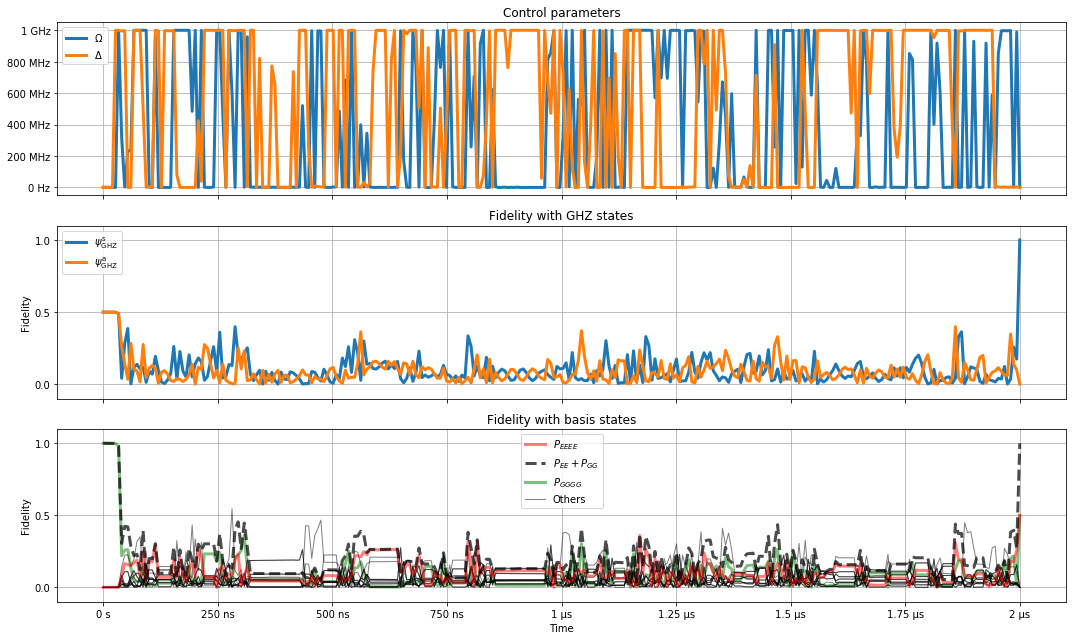

In [7]:
plot_optimresult(norm_result, N, norm_t, unnormalise_V=characteristic_V)

solved in 14.182
fidelity with GHZ: 1.0000 (with antisymmetric: 0.0000)
superposition probability: 1.0000 (g: 0.4997, e: 0.5003)



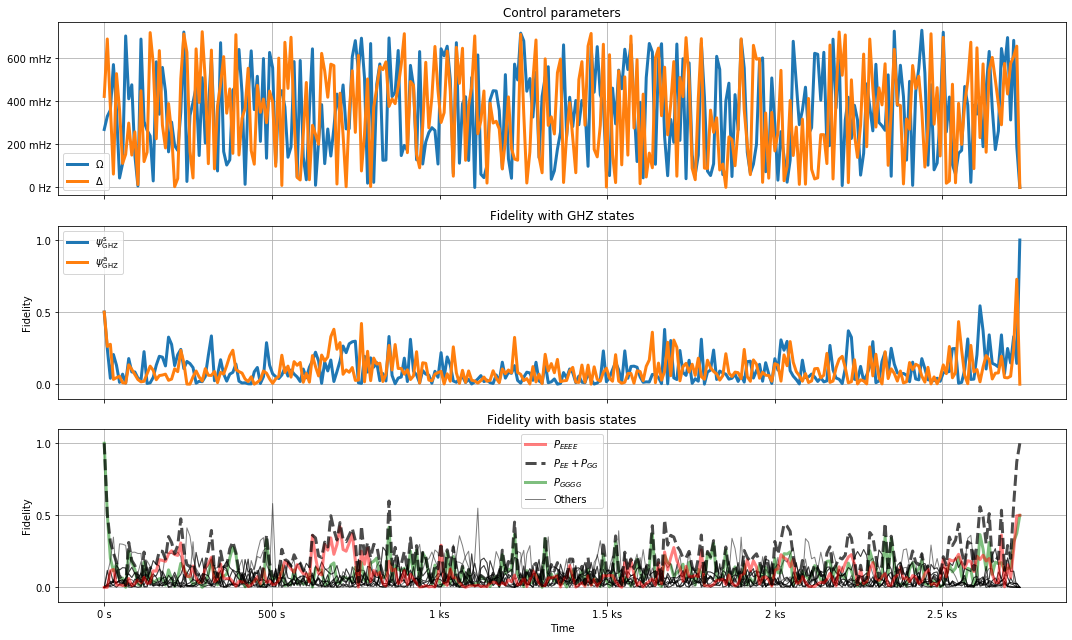

In [16]:
plot_optimresult_normalised(norm_result, N, norm_t)

no collapse operator, using sesolve
10.0%. Run time:   1.06s. Est. time left: 00:00:00:09
20.0%. Run time:   2.04s. Est. time left: 00:00:00:08
30.0%. Run time:   3.20s. Est. time left: 00:00:00:07
40.0%. Run time:   4.30s. Est. time left: 00:00:00:06
50.0%. Run time:   5.45s. Est. time left: 00:00:00:05
60.0%. Run time:   6.59s. Est. time left: 00:00:00:04
70.0%. Run time:   7.69s. Est. time left: 00:00:00:03
80.0%. Run time:   9.33s. Est. time left: 00:00:00:02
90.0%. Run time:  10.46s. Est. time left: 00:00:00:01
Total run time:  11.37s
solved in 11.377
fidelity with GHZ: 0.9994 (with antisymmetric: 0.0000)
superposition probability: 0.9994 (g: 0.5026, e: 0.4968)



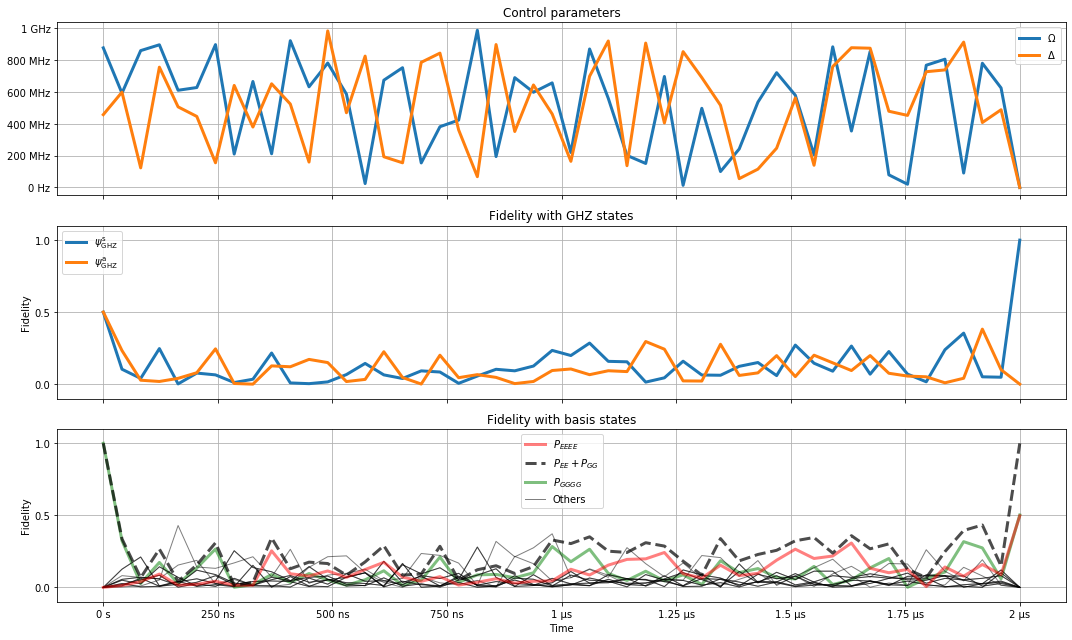

In [20]:
from qutip import Options, Qobj, sesolve
from qubit_system.utils.states import get_exp_list, get_ground_states, get_states, get_label_from_state
from qutip.ui import TextProgressBar

def test_solve(result: OptimResult, N: int, t: float, unnormalise_V: float = None):
    time = result.time
    final_Omega = np.hstack((result.final_amps[:, 0], result.final_amps[-1, 0]))
    final_Delta = np.hstack((result.final_amps[:, 1], result.final_amps[-1, 1]))
    if unnormalise_V is not None: 
        t /= unnormalise_V
        time = result.time / unnormalise_V
        final_Omega *= unnormalise_V
        final_Delta *= unnormalise_V
        
    e_qs = EvolvingQubitSystem(
        N=N, V=C6, geometry=RegularLattice1D(LATTICE_SPACING),
        Omega=get_hamiltonian_coeff_interpolation(time, final_Omega, "previous"),
        Delta=get_hamiltonian_coeff_interpolation(time, final_Delta, "previous"),
        t_list=np.linspace(0, t, 50),
        ghz_state=StandardGHZState(N)
    )
    hamiltonian = e_qs.get_hamiltonian()
    psi_0 = e_qs.psi_0
    t_list = np.linspace(0, t, 50)
    e_ops = get_exp_list(N)[2]
    
    import time
    start_time = time.time()
    solve_result = sesolve(
            hamiltonian,
            psi_0,
            t_list,
            # e_ops=e_ops,
            options=Options(store_states=True,atol=1e-5, nsteps=10000),
            # options=Options(method="bdf", atol=1e-8, store_states=True, nsteps=10000),
            _safe_mode=False,
            progress_bar=TextProgressBar()
        )
    print(f"solved in {time.time() - start_time:.3f}")
    
    e_qs.solve_result = solve_result
    fidelity_with_ghz = e_qs.get_fidelity_with("ghz")
    fidelity_with_ghz_asymmetric = e_qs.get_fidelity_with("ghz_antisymmetric")
    print(f"fidelity with GHZ: {fidelity_with_ghz:.4f} (with antisymmetric: {fidelity_with_ghz_asymmetric:.4f})")
    fidelity_with_ground = e_qs.get_fidelity_with("ground")
    fidelity_with_excited = e_qs.get_fidelity_with("excited")
    superposition_probability = fidelity_with_ground + fidelity_with_excited
    print(f"superposition probability: {superposition_probability:.4f} (g: {fidelity_with_ground:.4f}, e: {fidelity_with_excited:.4f})")
    e_qs.plot(with_antisymmetric_ghz=True)

test_solve(norm_result, N, norm_t, unnormalise_V=characteristic_V)

array([9.99959300e+08, 9.99948102e+08, 1.00000162e+09, 9.99923701e+08,
       9.99967598e+08, 1.00001359e+09, 9.99928943e+08, 9.99966261e+08,
       1.00000981e+09, 9.99972416e+08])